## Multi-Label Text Classification

### Kaggle link to the problem can be found [here](https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge)

### 1. Exploratory Data Analysis

In [1]:
import os
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Loading the data
df=pd.read_csv('data.csv')
df.shape

(159571, 8)

In [4]:
print('Number of samples in training data:',df.shape[0])
print('Number of features in training data:',df.shape[1])
print('Sample data:')
df.head()

Number of samples in training data: 159571
Number of features in training data: 8
Sample data:


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [5]:
# Checking for missing values
missing_val_check=df.isnull().sum()
print(missing_val_check)

id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64


In [7]:
# Calculating number of comments under each label
# Comments with no label are considered clean

rowSums=df.iloc[:,2:].sum(axis=1)
clean_comments_count=(rowSums==0).sum(axis=0)

print('Total no. of comments:', len(df))
print('No. of clean comments:',clean_comments_count)
print('No. of comments with labels:',len(df)-clean_comments_count)

Total no. of comments: 159571
No. of clean comments: 143346
No. of comments with labels: 16225


In [8]:
categories=list(df.columns.values)
categories=categories[2:]
print(categories)

['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']


In [9]:
# Calculating number of comments in each category
counts=[]
for cat in categories:
    counts.append((cat, df[cat].sum()))
df_stats=pd.DataFrame(counts, columns=['category', 'No. of comments'])
df_stats

,category,No. of comments
0,toxic,15294
1,severe_toxic,1595
2,obscene,8449
3,threat,478
4,insult,7877
5,identity_hate,1405


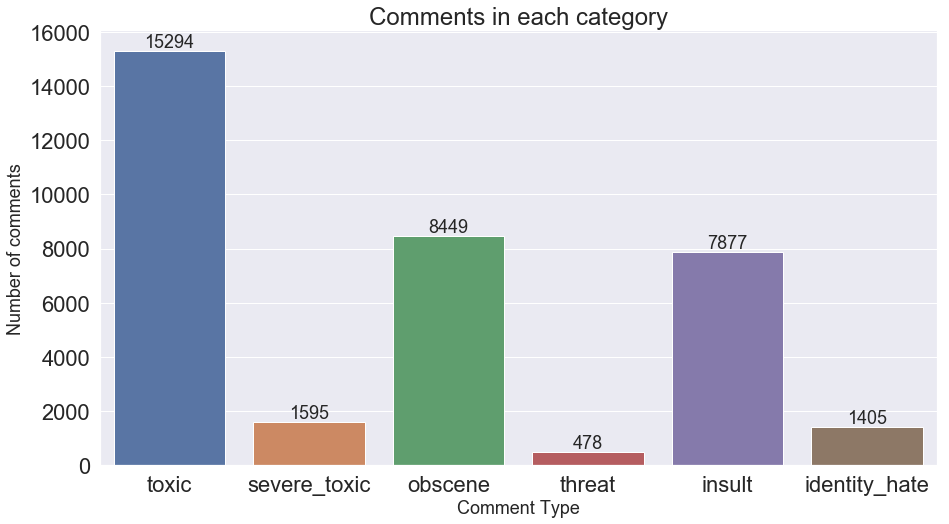

In [11]:
# plotting the number of comments in each category
sns.set(font_scale=2)
plt.figure(figsize=(15,8))
ax=sns.barplot(categories, df.iloc[:,2:].sum().values)

plt.title('Comments in each category', fontsize=24)
plt.ylabel('Number of comments', fontsize=18)
plt.xlabel('Comment Type', fontsize=18)

# adding the text labels
rects=ax.patches
labels=df.iloc[:,2:].sum().values
for rect, label in zip(rects, labels):
    ax.text((rect.get_x()+rect.get_width()/2), rect.get_height()+5, label, ha='center', va='bottom', fontsize=18)
plt.show()  

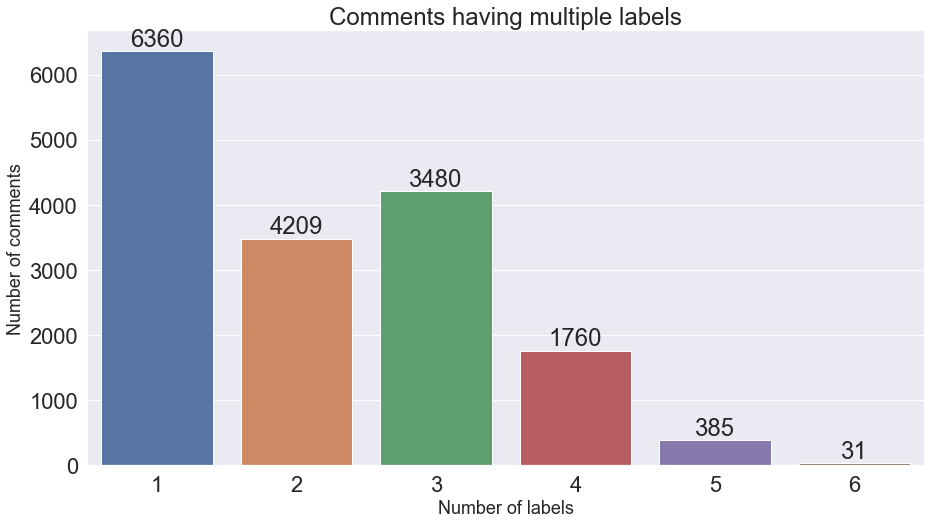

In [12]:
# Calculating number of comments having multiple labels
rowSums=df.iloc[:,2:].sum(axis=1)
multilabel_counts=rowSums.value_counts()
multilabel_counts=multilabel_counts.iloc[1:]

sns.set(font_scale=2)
plt.figure(figsize=(15,8))

ax=sns.barplot(multilabel_counts.index, multilabel_counts.values)

plt.title('Comments having multiple labels')
plt.ylabel('Number of comments', fontsize=18)
plt.xlabel('Number of labels', fontsize=18)

# adding the text labels
rects=ax.patches
labels=multilabel_counts.values
for rect, label in zip(rects, labels):
    ax.text((rect.get_x()+rect.get_width()/2), rect.get_height()+5, label, ha='center', va='bottom')
plt.show()

### 2. Data Preprocessing

In [13]:
import re
import sys
import warnings
import nltk
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer

In [16]:
if not sys.warnoptions:
    warnings.simplefilter('ignore')

# Functions for cleaning the data
def cleanHTML(sentence):
    """ To remove html tags """
    cleanr=re.compile('<.*?>')
    cleantext=re.sub(cleanr, ' ', str(sentence))
    return cleantext

def cleanPunc(sentence):
    """ To remove punctuations and special characters """
    cleaned=re.sub(r'[?|!|\'|"|#]', r'', sentence)
    cleaned=re.sub(r'[.|,|)|(|\|/]', r' ', sentence)
    cleaned=cleaned.strip()
    cleaned=cleaned.replace('\n',' ')
    return cleaned

def keepAlpha(sentence):
    """ To remove non-alphabetic characters """
    alpha_sent=''
    for word in sentence.split():
        alpha_word=re.sub('[^a-z A-Z]+', ' ', word)
        alpha_sent+=alpha_word
        alpha_sent+=' '
    alpha_sent=alpha_sent.strip()
    return alpha_sent    

In [20]:
# Using a random subset of data
df=df.loc[np.random.choice(df.index, size=2000)]
df['comment_text']=df['comment_text'].str.lower().apply(cleanHTML).apply(cleanPunc).apply(keepAlpha)
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
138177,e36b1255411443dd,nicholas v r mess page was just fine and dandy...,0,0,0,0,0,0
57214,98fa7d53b4763922,not if the election was fraudulent,0,0,0,0,0,0
70093,bb8388e3336e1b36,anybody it s still unsourced and still looks a...,0,0,0,0,0,0
122997,91fed76798609d74,futper between your editting history and your ...,0,0,0,0,0,0
34706,5cb3656f7485d425,economic policies neutral i wonder about the n...,0,0,0,0,0,0


In [22]:
# Removing stop words
stop_words=set(stopwords.words('english'))
stop_words.update(['zero','one','two','three','four','five','six','seven',
                   'eight','nine','ten','may','also','across','among','beside','however','yet','within'])
re_stop_words=re.compile(r'\b('+'|'.join(stop_words)+')\\W',re.I)

def removeStopWords(sentence):
    global re_stop_words
    return re_stop_words.sub(' ', sentence)

df['comment_text']=df['comment_text'].apply(removeStopWords)
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
138177,e36b1255411443dd,nicholas v r mess page fine dandy couple d...,0,0,0,0,0,0
57214,98fa7d53b4763922,election fraudulent,0,0,0,0,0,0
70093,bb8388e3336e1b36,anybody still unsourced still looks bit wi...,0,0,0,0,0,0
122997,91fed76798609d74,futper editting history negative stereotyp...,0,0,0,0,0,0
34706,5cb3656f7485d425,economic policies neutral wonder neutrality...,0,0,0,0,0,0


In [24]:
# Stemming
stemmer=SnowballStemmer('english')
def stemming(sentence):
    stemSentence=''
    for word in sentence.split():
        stem=stemmer.stem(word)
        stemSentence+=stem
        stemSentence+=' '
    stemSentence+=stemSentence.strip()
    return stemSentence
df['comment_text']=df['comment_text'].apply(stemming)
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
138177,e36b1255411443dd,nichola v r mess page fine dandi coupl day ago...,0,0,0,0,0,0
57214,98fa7d53b4763922,elect fraudul elect fraudul,0,0,0,0,0,0
70093,bb8388e3336e1b36,anybodi still unsourc still look bit wierd way...,0,0,0,0,0,0
122997,91fed76798609d74,futper edit histori negat stereotyp comment gr...,0,0,0,0,0,0
34706,5cb3656f7485d425,econom polici neutral wonder neutral statement...,0,0,0,0,0,0


In [25]:
# performing train-test split
from sklearn.model_selection import train_test_split
train, test=train_test_split(df, random_state=42, test_size=0.3, shuffle=True)
print(train.shape)
print(test.shape)

(1400, 8)
(600, 8)


In [26]:
train_text=train['comment_text']
test_text=test['comment_text']

In [27]:
# making numerical vectors from comments using tf-idf
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer=TfidfVectorizer(strip_accents='unicode', analyzer='word', ngram_range=(1,3), norm='l2')
vectorizer.fit(train_text)
vectorizer.fit(test_text)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 3), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words=None, strip_accents='unicode', sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

In [28]:
x_train=vectorizer.transform(train_text)
y_train=train.drop(labels=['id','comment_text'],axis=1)
x_test=vectorizer.transform(test_text)
y_test=test.drop(labels=['id','comment_text'],axis=1)

### 3. Multi-Label Classification

#### Multiple Binary Classifications (One vs Rest)

In [29]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.multiclass import OneVsRestClassifier

In [30]:
# Using pipeline for applying logistic regression and OvR Classifier
LogReg_pipeline=Pipeline([('clf',OneVsRestClassifier(LogisticRegression(solver='sag'),n_jobs=-1)),])

for cat in categories:
    print('Processing',cat,'comments...')
    # Training model
    LogReg_pipeline.fit(x_train, train[cat])
    # Calculating test accuracy
    prediction=LogReg_pipeline.predict(x_test)
    print('Test accuracy is',accuracy_score(test[cat], prediction))
    print('\n')

Processing toxic comments...
Test accuracy is 0.91


Processing severe_toxic comments...
Test accuracy is 0.991666666667


Processing obscene comments...
Test accuracy is 0.943333333333


Processing threat comments...
Test accuracy is 1.0


Processing insult comments...
Test accuracy is 0.948333333333


Processing identity_hate comments...
Test accuracy is 0.991666666667




#### Multiple Binary Classification - (Binary Relevance)

In [31]:
# using binary relevance
from skmultilearn.problem_transform import BinaryRelevance
from sklearn.naive_bayes import GaussianNB

# initialize binary relevance multi-label classifier
# with a gaussian naive bayes base classifier
classifier=BinaryRelevance(GaussianNB())

# Training the classifier
classifier.fit(x_train, y_train)
# Predict
predictions=classifier.predict(x_test)

# accuracy
print('Accuracy =',accuracy_score(y_test, predictions))
print('\n')

Accuracy = 0.885




#### Classifier Chains

In [33]:
# using classifier chains
from skmultilearn.problem_transform import ClassifierChain
from sklearn.linear_model import LogisticRegression

In [34]:
# initialize classifier chains multi-label classifier
classifier=ClassifierChain(LogisticRegression())

# training logistic regression model on train data
classifier.fit(x_train, y_train)
# predict
predictions=classifier.predict(x_test)

# accuracy
print('Accuracy =',accuracy_score(y_test, predictions))
print('\n')

Accuracy = 0.905




#### Label Powerset

In [35]:
# using label powerset
from skmultilearn.problem_transform import LabelPowerset

In [38]:
# initialize label powerset multi-label classifier
classifier=LabelPowerset(LogisticRegression())

# train
classifier.fit(x_train, y_train)

#predict
predictions=classifier.predict(x_test)

#accuracy
print('Accuracy =',accuracy_score(y_test, predictions))
print('\n')

Accuracy = 0.905




#### Adapted Algorithm

In [40]:
from skmultilearn.adapt import MLkNN
from scipy.sparse import lil_matrix

In [41]:
classifier = MLkNN(k=10)

# this classifier can throw up errors when handling sparse matrices
x_train=lil_matrix(x_train).toarray()
y_train=lil_matrix(y_train).toarray()
x_test=lil_matrix(x_test).toarray()

# train
classifier.fit(x_train, y_train)

# predict
predictions=classifier.predict(x_test)

# accuracy
print('Accuracy =', accuracy_score(y_test, predictions))
print('\n')

Accuracy = 0.908333333333


